## Winoground ViLT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/PhD/2022 Julen Etxaniz EHU/MAL/winoground/evaluation

/content/drive/MyDrive/PhD/2022 Julen Etxaniz EHU/MAL/winoground/evaluation


# Install Dependencies

In [3]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 33.9 MB/s 
     |████████████████████████████████| 101 kB 13.5 MB/s 
     |████████████████████████████████| 6.6 MB 58.1 MB/s 
     |████████████████████████████████| 596 kB 55.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 29.4 MB/s 
     |████████████████████████████████| 212 kB 65.5 MB/s 
     |████████████████████████████████| 141 kB 71.4 MB/s 
     |████████████████████████████████| 127 kB 76.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolv

# Load Winoground (enter a huggingface user token or it will fail)

Easily get a token by logging into https://huggingface.co/, clicking on your user profile -> settings -> access tokens -> new token

In [1]:
def get_token():
    with open("../token.txt") as f:
        return f.read()

In [2]:
from datasets import load_dataset
# Replace with an auth token, which you can get from your huggingface account: Profile -> Settings -> Access Tokens -> New Token
auth_token = get_token()
winoground = load_dataset("facebook/winoground", use_auth_token=auth_token)["test"]

Reusing dataset winoground (/gaueko0/users/jetxaniz007/.cache/huggingface/datasets/facebook___winoground/default/0.0.0/ce486f3e39fab90997d6f3c58c4b0103eb9c37011049ef775a465f0ab2e78d7d)


  0%|          | 0/1 [00:00<?, ?it/s]

# Load ViLT

In [3]:
from transformers import ViltProcessor, ViltForImagesAndTextClassification
path = "../../visual-spatial-reasoning/tmp/vilt_zeroshot_split/best_checkpoint"
vilt_model = ViltForImagesAndTextClassification.from_pretrained(path).to("cuda")
vilt_processor = ViltProcessor.from_pretrained(path)

# Look at an example from Winoground and get the image-caption scores from ViLT

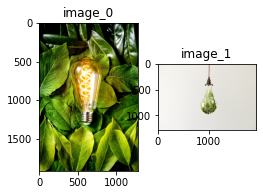

caption_0: some plants surrounding a lightbulb
caption_1: a lightbulb surrounding some plants


In [4]:
from matplotlib import pyplot as plt

def show_example(id):
    ax1 = plt.subplot(1, 3, 1)
    ax1.title.set_text('image_0')
    plt.imshow(winoground[id]["image_0"].convert("RGB"))

    ax2 = plt.subplot(1, 3, 2)
    ax2.title.set_text('image_1')
    plt.imshow(winoground[id]["image_1"].convert("RGB"))

    plt.show()

    print("caption_0:", winoground[id]["caption_0"])
    print("caption_1:", winoground[id]["caption_1"])

show_example(id=155)

In [5]:
def get_vilt_scores(id):
    # Note that some images in winoground are RGBA and some are RGB. Need to convert all to RGB with .convert('RGB')
    # Note that we could run this example through ViLT as a batch, but I want to drive the point home that we get four independent image-caption scores for each example
    text_0 = winoground[id]["caption_0"]
    text_1 = winoground[id]["caption_1"]
    image_0 = winoground[id]["image_0"].convert("RGB")
    image_1 = winoground[id]["image_1"].convert("RGB")

    input_c0_i0 = vilt_processor(text=text_0, images=image_0, return_tensors="pt").to("cuda")
    input_c1_i0 = vilt_processor(text=text_1, images=image_0, return_tensors="pt").to("cuda")
    input_c0_i1 = vilt_processor(text=text_0, images=image_1, return_tensors="pt").to("cuda")
    input_c1_i1 = vilt_processor(text=text_1, images=image_1, return_tensors="pt").to("cuda")

    output_c0_i0 = vilt_model(input_ids=input_c0_i0.input_ids, pixel_values=input_c0_i0.pixel_values.unsqueeze(0))
    output_c1_i0 = vilt_model(input_ids=input_c1_i0.input_ids, pixel_values=input_c1_i0.pixel_values.unsqueeze(0))
    output_c0_i1 = vilt_model(input_ids=input_c0_i1.input_ids, pixel_values=input_c0_i1.pixel_values.unsqueeze(0))
    output_c1_i1 = vilt_model(input_ids=input_c1_i1.input_ids, pixel_values=input_c1_i1.pixel_values.unsqueeze(0))
    
    vilt_score_c0_i0 = output_c0_i0.logits[0][1].item()
    vilt_score_c1_i0 = output_c1_i0.logits[0][1].item()
    vilt_score_c0_i1 = output_c0_i1.logits[0][1].item()
    vilt_score_c1_i1 = output_c1_i1.logits[0][1].item()

    vilt_scores = {"id": id, "c0_i0": vilt_score_c0_i0, "c0_i1": vilt_score_c0_i1, "c1_i0": vilt_score_c1_i0, "c1_i1": vilt_score_c1_i1}
    return vilt_scores

vilt_scores = get_vilt_scores(id=155)

In [6]:
def print_scores(scores):
    print("image_0, caption_0:", scores["c0_i0"])
    print("image_0, caption_1:", scores["c1_i0"])
    print("image_1, caption_0:", scores["c0_i1"])
    print("image_1, caption_1:", scores["c1_i1"])

print("ViLT image-text match scores:")
print_scores(vilt_scores)

ViLT image-text match scores:
image_0, caption_0: 2.332303285598755
image_0, caption_1: 2.073657989501953
image_1, caption_0: 2.018949270248413
image_1, caption_1: 1.3153820037841797


# Get ViLT image-caption scores from the whole dataset

In [7]:
from tqdm import tqdm

def get_all_vilt_scores():  
    winoground_vilt_scores = []
    for id in tqdm(range(len(winoground))):
        vilt_scores = get_vilt_scores(id=id)
        winoground_vilt_scores.append(vilt_scores)
    return winoground_vilt_scores

winoground_vilt_scores = get_all_vilt_scores()

100%|██████████| 400/400 [02:58<00:00,  2.24it/s]


In [8]:
def save_results(filename, winoground_scores):
    with open(filename, 'w') as f:
        for scores in winoground_scores:
            f.write(f'{{"label": "{scores["id"]}_c0_i0", "score": {scores["c0_i0"]}}}\n')
            f.write(f'{{"label": "{scores["id"]}_c0_i1", "score": {scores["c0_i1"]}}}\n')
            f.write(f'{{"label": "{scores["id"]}_c1_i0", "score": {scores["c1_i0"]}}}\n')
            f.write(f'{{"label": "{scores["id"]}_c1_i1", "score": {scores["c1_i1"]}}}\n')

save_results("../results/scores/vilt_vsr_zeroshot.jsonl", winoground_vilt_scores)

# Define the text, image, and group metrics, and compute the overall performance of ViLT

In [9]:
def text_correct(result):
    return result["c0_i0"] > result["c1_i0"] and result["c1_i1"] > result["c0_i1"]

def image_correct(result):
    return result["c0_i0"] > result["c0_i1"] and result["c1_i1"] > result["c1_i0"]

def group_correct(result):
    return image_correct(result) and text_correct(result)

def print_performance(winoground_scores):
    text_correct_count = 0
    image_correct_count = 0
    group_correct_count = 0
    for result in winoground_scores:
        text_correct_count += 1 if text_correct(result) else 0
        image_correct_count += 1 if image_correct(result) else 0
        group_correct_count += 1 if group_correct(result) else 0

    denominator = len(winoground_scores)
    print("text score:", text_correct_count/denominator)
    print("image score:", image_correct_count/denominator)
    print("group score:", group_correct_count/denominator)

print("ViLT scores:")
print_performance(winoground_vilt_scores)

ViLT scores:
text score: 0.295
image score: 0.14
group score: 0.0925
